# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# 1. Загрузка и подготовка данных

In [43]:
import pandas as pd

# деление на обучающие, тестовые, и валидационные выборки
from sklearn.model_selection import train_test_split

# стандартизация независимых переменных
from sklearn.preprocessing import StandardScaler


# модель линейной регрессии
from sklearn.linear_model import LinearRegression

# метрика mse
from sklearn.metrics import mean_squared_error

Загрузим данные и посмотрим на них

In [44]:

geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
display(geo_data_1.head())

geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
display(geo_data_2.head())

geo_data_3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')
display(geo_data_3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Отлично, данные загрузились корректно. Но у нас получилось 3 датафрейма. Чтобы выполнить проверку данных за 1 раз, а не повторять действия 3 раза - добавим каждому датафрейму столбец-идентификатор региона и соберем все данные в 1 датасет

In [45]:
geo_data_1['region']=1
geo_data_2['region']=2
geo_data_3['region']=3

#print(geo_data_1.shape)
#print(geo_data_2.shape)
#print(geo_data_3.shape)

geo_data = geo_data_1.append(geo_data_2)
geo_data = geo_data.append(geo_data_3).copy()

display(geo_data)

,id,f0,f1,f2,product,region
0,txEyH,0.705745,-0.497823,1.221170,105.280062,1
1,2acmU,1.334711,-0.340164,4.365080,73.037750,1
2,409Wp,1.022732,0.151990,1.419926,85.265647,1
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,1
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,1
...,...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046,3
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846,3
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080,3
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253,3


Данные загрузили и собрали, теперь можно заняться подготовкой. Посмотрим на имена столбцов и если нужно, то переименуем. Затем посмотрим на тип переменных и исправим если нужно. После это проверим на наличие явных дублей и почистим если необходимо. И наконец посмотрим на пропуски значений и обработаем если будет такая необходимость.

In [46]:
print('названия столбцов:',geo_data.columns)
print('типы данных:\n',geo_data.dtypes)
print('всего явных дублей:',geo_data.duplicated().sum())
print('всего пропусков данных:\n',geo_data.isna().sum())

названия столбцов: Index(['id', 'f0', 'f1', 'f2', 'product', 'region'], dtype='object')
типы данных:
 id          object
f0         float64
f1         float64
f2         float64
product    float64
region       int64
dtype: object
всего явных дублей: 0
всего пропусков данных:
 id         0
f0         0
f1         0
f2         0
product    0
region     0
dtype: int64


Отлично. Нам дали кашерные исходные данны. Можно переходить к обучению и проверке модели.

# 2. Обучение и проверка модели

По условию задачи "для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые)", поэтому будем использовать ее. Однако, перед тем как использовать линейную регрессию нам нужно сначала разбить данные на обучающию и валидационную выборку. Делать это будем в соотношении 75:25. При этом следует помнить, что работаем мы все же с 3 датафреймами для каждого региона, поэтому обучение и проверку моделей необходимо будет сделать 3 раза, а значит имеет смысл писать функции, а не плодить однотипный код.

In [47]:
# напишем функию для разбиения выборки на тренировочную и валидационную. Стандартизируем независимые переменные

def split_data(data):
    # определим зависимые и независимые переменные
    target = data['product']
    
    # не забываем удалить регион, который мы довабляли, чтоб склеить данные, а так же идентификатор скважины
    features = data.drop(['product','region','id'], axis=1)

    # сначала выделим тестовую выборку и тренировочкую
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)


    # определим все числовие независимые переменные
    numeric = ['f0', 'f1', 'f2']


    # обучим стандартизации на тренировочных данных
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])




    # стандартизируем выборки
    features_train_scaler = features_train.copy() 
    features_valid_scaler = features_valid.copy()

    features_train_scaler[numeric] = scaler.transform(features_train[numeric])
    features_valid_scaler[numeric] = scaler.transform(features_valid[numeric])

    
    return features_train_scaler, features_valid_scaler, target_train, target_valid


# разделим выборку для 1 региона
features_train_1, features_valid_1, target_train_1, target_valid_1 = split_data(geo_data_1)

# разделим выборку для 2 региона
features_train_2, features_valid_2, target_train_2, target_valid_2 = split_data(geo_data_2)

# разделим выборку для 3 региона
features_train_3, features_valid_3, target_train_3, target_valid_3 = split_data(geo_data_3)


#display(features_train_1.head())
#display(features_train_1.shape)

Отлично, данные разбили. Теперь сделаем аналогичную функцию для обучения модели линейной регрессии на обучающих данных. Функцию будет возвращать обученную модель и предсказания сделанные на валидационных данных

In [48]:
def learn_model(num, features_train, features_valid, target_train, target_valid):
    model=LinearRegression()
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    mse = mean_squared_error(target_valid, predictions_valid)
    
    print("Регион ", num)
    print('средний предсказанный запас сырья: {:.3f}'.format(predictions_valid.mean()))
    print('средний реальный запас сырья: {:.3f}'.format(target_valid.mean()))
    print('rmse запаса сырья: {:.3f}'.format( mse**0.5))
    print()
    
    return mse, predictions_valid

mse_1, predictions_1 = learn_model(1, features_train_1, features_valid_1, target_train_1, target_valid_1)

mse_2, predictions_2 = learn_model(2, features_train_2, features_valid_2, target_train_2, target_valid_2)

mse_3, predictions_3 = learn_model(3, features_train_3, features_valid_3, target_train_3, target_valid_3)




Регион  1
средний предсказанный запас сырья: 92.593
средний реальный запас сырья: 92.079
rmse запаса сырья: 37.579

Регион  2
средний предсказанный запас сырья: 68.729
средний реальный запас сырья: 68.723
rmse запаса сырья: 0.893

Регион  3
средний предсказанный запас сырья: 94.965
средний реальный запас сырья: 94.884
rmse запаса сырья: 40.030



Как видим, по предсказанным данным в 3 регионе самые большие средние запасы сырья на 1 скважину. При этом там же и самая большая возможная ошибка, то есть средний разброс между очень "наполненными" и очень "пустыми" скважинами там больше. В регионе 2 самый маленький средний запас сырья на 1 скажину, при этом очень маленький rmse, что может говорить о том, что в регионе все скважины примерно одинаково "наполнены". 

Посмотрим на гистограммы "наполненности" скважин по регионам.

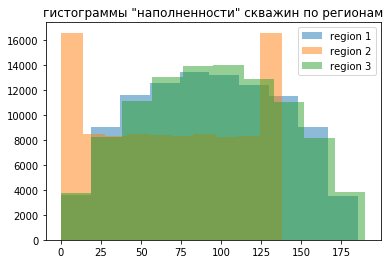

In [49]:
import matplotlib.pyplot as plt
x_1 = geo_data_1['product']
x_2 = geo_data_2['product']
x_3 = geo_data_3['product']

plt.hist(x_1, alpha=0.5, bins=10, label='region 1')
plt.hist(x_2, alpha=0.5, bins=10, label='region 2')
plt.hist(x_3, alpha=0.5, bins=10, label='region 3')
plt.legend(loc='upper right')
plt.title('гистограммы "наполненности" скважин по регионам')
plt.show()

Как и предполагалось, во втором регионе все скважины примерно равны, но есть выбросы c большой (для региона) и малой (для всех рассматриваемых регионов) наполняемостью скважин.

Касательно 1 и 3 региона - они достаточно пожожи, однако гистограма "наполненности" скважин в 3 регионе смещена вправо, а значит и медианное значение "заполненности" там выше. Однако предсказанный средний запас сырья в 1 и 3 регионе различается на 2тыс. баррелей, а rmse на 3 тыс. баррелей. Все это может говорить о том, что третий регион может и выглядит на гистограмме, как более привлекательный для инвестиций, на деле же, первый и третий регионы примерно одинаковы.

Проверим выводы относительно первого и третьего региона на данных.

In [50]:
print(x_1.mean())
print(x_3.mean())
print(x_1.median())
print(x_3.median())

92.50000000000001
95.00000000000004
91.84997204396296
94.92561258990246


Как видим, наши выводы верны.

# 3. Подготовка к расчёту прибыли

Для расчета прибыли нам необходимо написать функцию. По условиям задания:

- При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для расчёта прибыли.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Используем эти данные чтоб посчитать прибыль по 200 лучшим скважинам. 500 случайных скважин мы будем отбирать позже, когда будем делать функцию для бутстрапа.

In [51]:
# объявим глобальные переменные
profit_per_burrel = 450
total_budget = 10**10
total_points_for_bootstrap = 500
quantity_of_best_points = 200

# напишем функцию, которая считает прибыль как прибыль со всего добытого из 200 лучших, 
# согласно прогнозу, скважин  минус бюджет на регион

def profit(target, predictions):
    # преобразуем предсказанную "наполняемость" из массива numpy в pandas series
    predictions = pd.Series(predictions)
    target = target.reset_index(drop=True)
    predictions = predictions.reset_index(drop=True)
    
    # отсортируем по убванию предсказанной "наполняемости" скважины
    predictions_sorted = predictions.sort_values(ascending=False)
   

    # возмем 200 лучших скважин, они же 200 первых в отсортированном списке
    sort = predictions_sorted[:quantity_of_best_points]

    # для этих 200 скважин возьмем реальные, а не предсказанные значения их "наполняемости"
    selected = target[sort.index][:quantity_of_best_points]
   
    # посчитаем профит как профит с добытого минус бюджет на запуск
    profit = profit_per_burrel*selected.sum()*1000-total_budget
    
    return (profit, selected)

# посчитаем прибыль в каждом регионе
profit_1, top200_1 = profit(target_valid_1, predictions_1)
profit_2, top200_2= profit(target_valid_2, predictions_2)
profit_3, top200_3 = profit(target_valid_3, predictions_3)

print("прибыль 1 региона до бутстрапа:{:.4f}".format(profit_1))
print("прибыль 2 региона до бутстрапа:{:.4f}".format(profit_2))
print("прибыль 3 региона до бутстрапа:{:.4f}".format(profit_3))


прибыль 1 региона до бутстрапа:3320826043.1399
прибыль 2 региона до бутстрапа:2415086696.6815
прибыль 3 региона до бутстрапа:2710349963.5998


<font color='blue'>
Посчитаем необходимую "наполняемость" скважины для безубыточной разработки и сравним со средней "наполняемостью" 200 лучших скважин в регионе.
</font>

In [52]:
print('Для безубыточной разработки скважина должа содержать {:.2f}тыс. баррелей'.format(total_budget/200/(profit_per_burrel*1000)))
print('Средние запасы сырья в скважинах 1 региона {:.2f}тыс. баррелей'.format(top200_1.mean()))
print('Средние запасы сырья в скважинах 2 региона {:.2f}тыс. баррелей'.format(top200_2.mean()))
print('Средние запасы сырья в скважинах 3 региона {:.2f}тыс. баррелей'.format(top200_3.mean()))

Для безубыточной разработки скважина должа содержать 111.11тыс. баррелей
Средние запасы сырья в скважинах 1 региона 148.01тыс. баррелей
Средние запасы сырья в скважинах 2 региона 137.95тыс. баррелей
Средние запасы сырья в скважинах 3 региона 141.23тыс. баррелей


Отлично, функцию подсчета прибыли по 200 лучшим скважинам мы написали, <font color='blue'>а заодно посчитали необходимый запас сырья в скважине, для безубыточной разработки</font>. Пока все выглядит так, как-будто имеет смысл вкладываться в 1 регион в первую очередь, <font color='blue'>там больше средние запасы сырья на 1 скважину и как следствие прибыль (при этом во всех регионах 200 лучших скважин имеют средние запасы выше порогового значения для безубыточной разработки)</font>. Так ли это? <font color='blue'>Поскольку в нашей модели прибыль линейно зависима от "наполняемости" скважин, то будем работать напрямую с прибылью, но при сдаче результатов заказчику, все же лучше явно указать минимальный объем сырья в скважине для безубыточной разработки. </font> Напишем функцию бутстрапа, которая 1000 раз будет случайным образом отбирать с возвращением 500 случайных точек и передавать их в функцию подсчета прибыли и посмотрим, какова средняя прибыль из этих 1000 итераций для каждого региона.

In [53]:
import numpy as np
def bootstrap (target, predictions):
    state = np.random.RandomState(12345)
    
    predictions = pd.Series(predictions)
    target = target.reset_index(drop=True)
    predictions = predictions.reset_index(drop=True)
    
    profits = []
    for i in range(1000):
        # выбираем из нашего фрейма случайным образом 500 скважин с возвращением
        target_subsample = target.sample(n=total_points_for_bootstrap, replace=True, random_state= state)
        
        # для этих 500 скважин берем те значения "наполняемости", что нам предсказала модель
        predictions_subsample = predictions[target_subsample.index]
        
        # считаем реальную, а не модельную прибыль для 200 лучших скважин из этих 500
        prof, top = profit(target_subsample,  predictions_subsample)

        profits.append(prof)
        
    return pd.Series(profits)

# посчитаем бутстрапом, на 1000 выборках среднюю прибыль с 200 лучших скважин из 500 отобранных с возвращением
bootstrap_profit_1 = bootstrap(target_valid_1, predictions_1)
bootstrap_profit_2 = bootstrap(target_valid_2, predictions_2)
bootstrap_profit_3 = bootstrap(target_valid_3, predictions_3)

print ("Средняя прибыль 1 региона по бутстрапу:{:.0f}".format(bootstrap_profit_1.mean()))
print ("Средняя прибыль 2 региона по бутстрапу:{:.0f}".format(bootstrap_profit_2.mean()))
print ("Средняя прибыль 3 региона по бутстрапу:{:.0f}".format(bootstrap_profit_3.mean()))

Средняя прибыль 1 региона по бутстрапу:396164985
Средняя прибыль 2 региона по бутстрапу:456045106
Средняя прибыль 3 региона по бутстрапу:404403867


Явный аутсайдер по прибыли "в лоб", второй регион, неожиданно стал лидером и теперь уже не выглядит таким уж мало перспективным по сравнению с другими регионами.

# 4. Расчёт прибыли и рисков 

Поскольку прибыль мы расчитали на предыдущем шаге, расчитаем риски. По условию задания, риски прибыли и убытков считаются на 95% доверительном интервале. Для расчета рисков напишем отдельную функцию.

In [54]:
from scipy import stats as st

# напишем функцию расчета доверительного интервала и рисков
def confidence_interval(sample):
    sample=pd.Series(sample)
    
    # расчитаем 95% доверительный интервал (интервал, в котором с вероятностью 95% будет лежать истенное значение прибыли)
    #interval = st.t.interval(alpha=0.95, df=len(sample)-1, loc=sample.mean(), scale=sample.sem())
    
    interval='('+str(sample.quantile(0.025))+','+str(sample.quantile(0.975))+')'
    
    # расчитаем среднее значение прибыли
    sample_mean = sample.mean()
    
    # расчитаем значение прибыли при уровне риска в 2.5%
    # проведя аналогию можно сказать, что мы сортируем по убыванию, берем блок из 2.5% худших результатов
    # и смотрим на лучшее значение из них
    lower = sample.quantile(0.025)
    
    # расчитаем с какой вероятностью мы вообще получим убыток
    # другими словами мы смотрим долю отризательных прибылей в массиве.
    risk = (sample<0).mean()
    
    return interval, sample_mean, lower, risk

# расчитаем доверительный интервал для средней прибыли каждого региона после бутстрапа и выведем основные параметры регионов

def region_info(region_number, df):
    
    interval, mean, lower, risk = confidence_interval(df)
    print('статистика {} региона'.format(region_number))
    print('среднее значение прибыли: {:.4f}'.format(mean))
    print('2.5%-квантиль:', lower)
    print('95% доверительный интервал', interval)
    print('риск убытков', risk)
    print()


region_info(1,bootstrap_profit_1)
region_info(2,bootstrap_profit_2)
region_info(3,bootstrap_profit_3)


статистика 1 региона
среднее значение прибыли: 396164984.8024
2.5%-квантиль: -111215545.89049526
95% доверительный интервал (-111215545.89049526,909766941.5534225)
риск убытков 0.069

статистика 2 региона
среднее значение прибыли: 456045105.7867
2.5%-квантиль: 33820509.39898549
95% доверительный интервал (33820509.39898549,852289453.8660344)
риск убытков 0.015

статистика 3 региона
среднее значение прибыли: 404403866.5684
2.5%-квантиль: -163350413.3955992
95% доверительный интервал (-163350413.3955992,950359574.9238014)
риск убытков 0.076



Таким образом, единственным решионом, который мы можем рекомендовать для разработки, с риском убытков не более 2.5% является второй регион. В нем с вероятностью 95% можно заработать от <font color='blue'>33млн 820тыс 509 рублей до  852млн 289тыс 454рублей </font> , а ориентироваться следует на цифру в 456млн 045тыс 106рублей. При этом риск убытков в этом регионе составляет 1.5%. 

В первом и третем регионах риски убытков составляют 6.9% и 7.6% соответственно, а при заданном уровне риска в 2.5% и вовсе получаем чистый убыток в каждом из этих регионов. 